/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:48:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Random Forest Model Performance:
Accuracy: 0.9137931034482759
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.92        63
           1       0.94      0.87      0.90        53

    accuracy                           0.91       116
   macro avg       0.92      0.91      0.91       116
weighted avg       0.92      0.91      0.91       116

Confusion Matrix:
 [[60  3]
 [ 7 46]]

XGBoost Model Performance:
Accuracy: 0.9137931034482759
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.92        63
           1       0.94      0.87      0.90        53

    accuracy                           0.91       116
   macro avg       0.92      0.91      0.91       116
weighted avg       0.92      0.91      0.91       116

Confusion Matrix:
 [[60  3]
 [ 7 46]]

SVM Model Performance:
Accuracy: 0.8706896551724138
Classification Report:
               precision  

<ipython-input-1-6dfcfd9c2ca7>:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='coolwarm')


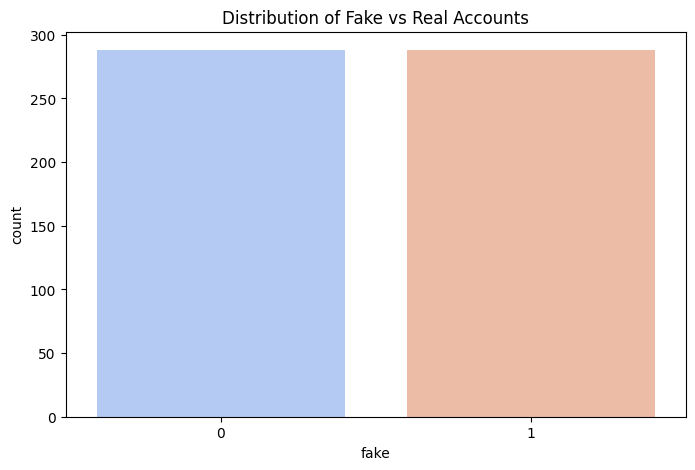

<ipython-input-1-6dfcfd9c2ca7>:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance, y=feature_importance.index, palette='viridis')


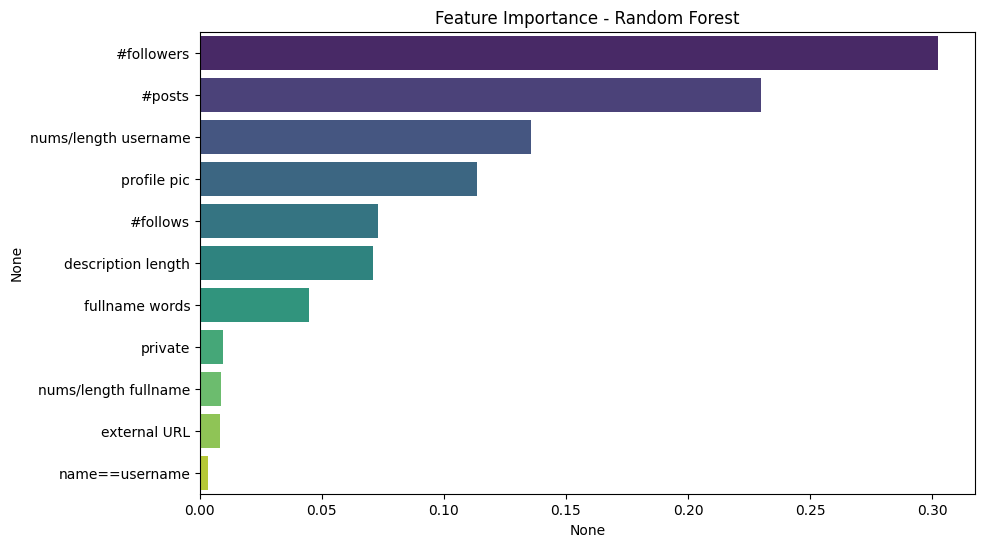

<ipython-input-1-6dfcfd9c2ca7>:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance, y=feature_importance.index, palette='viridis')


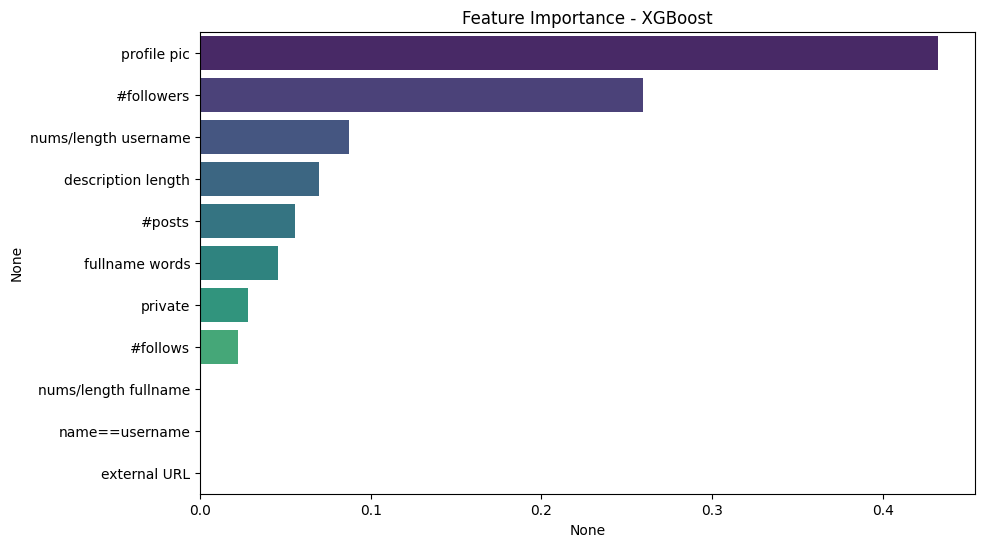

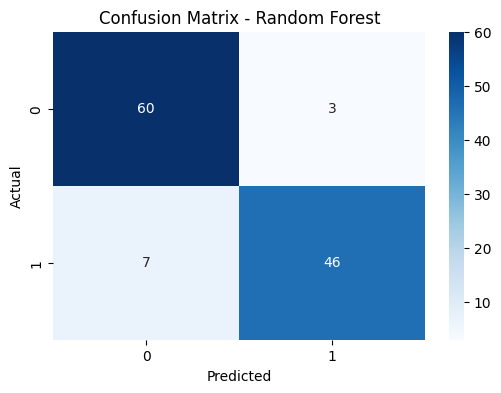

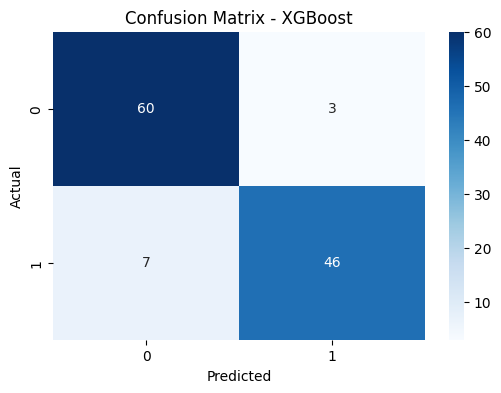

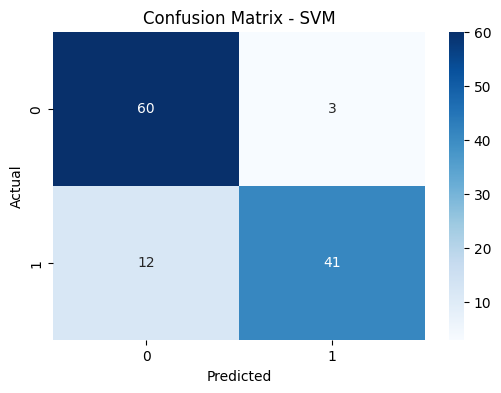

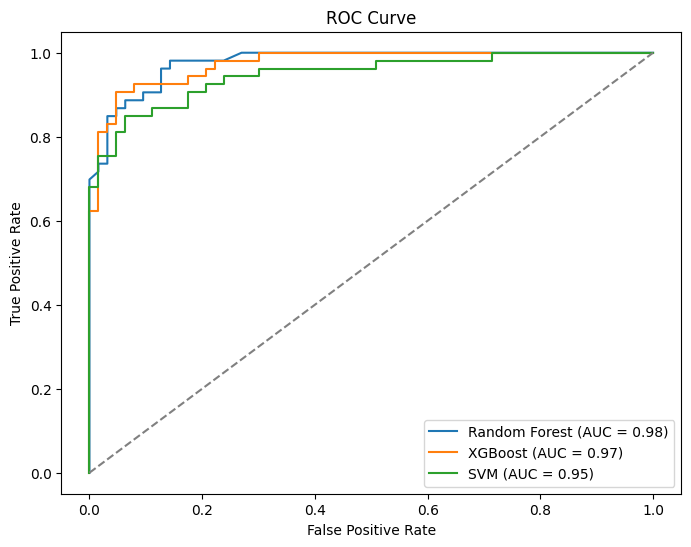

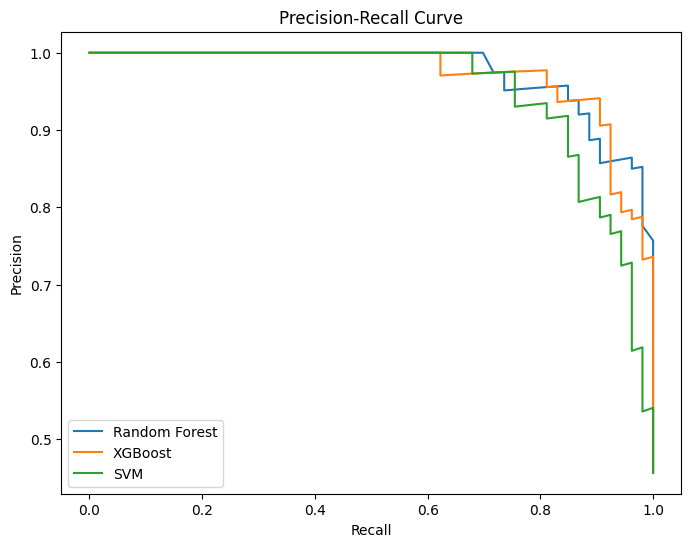

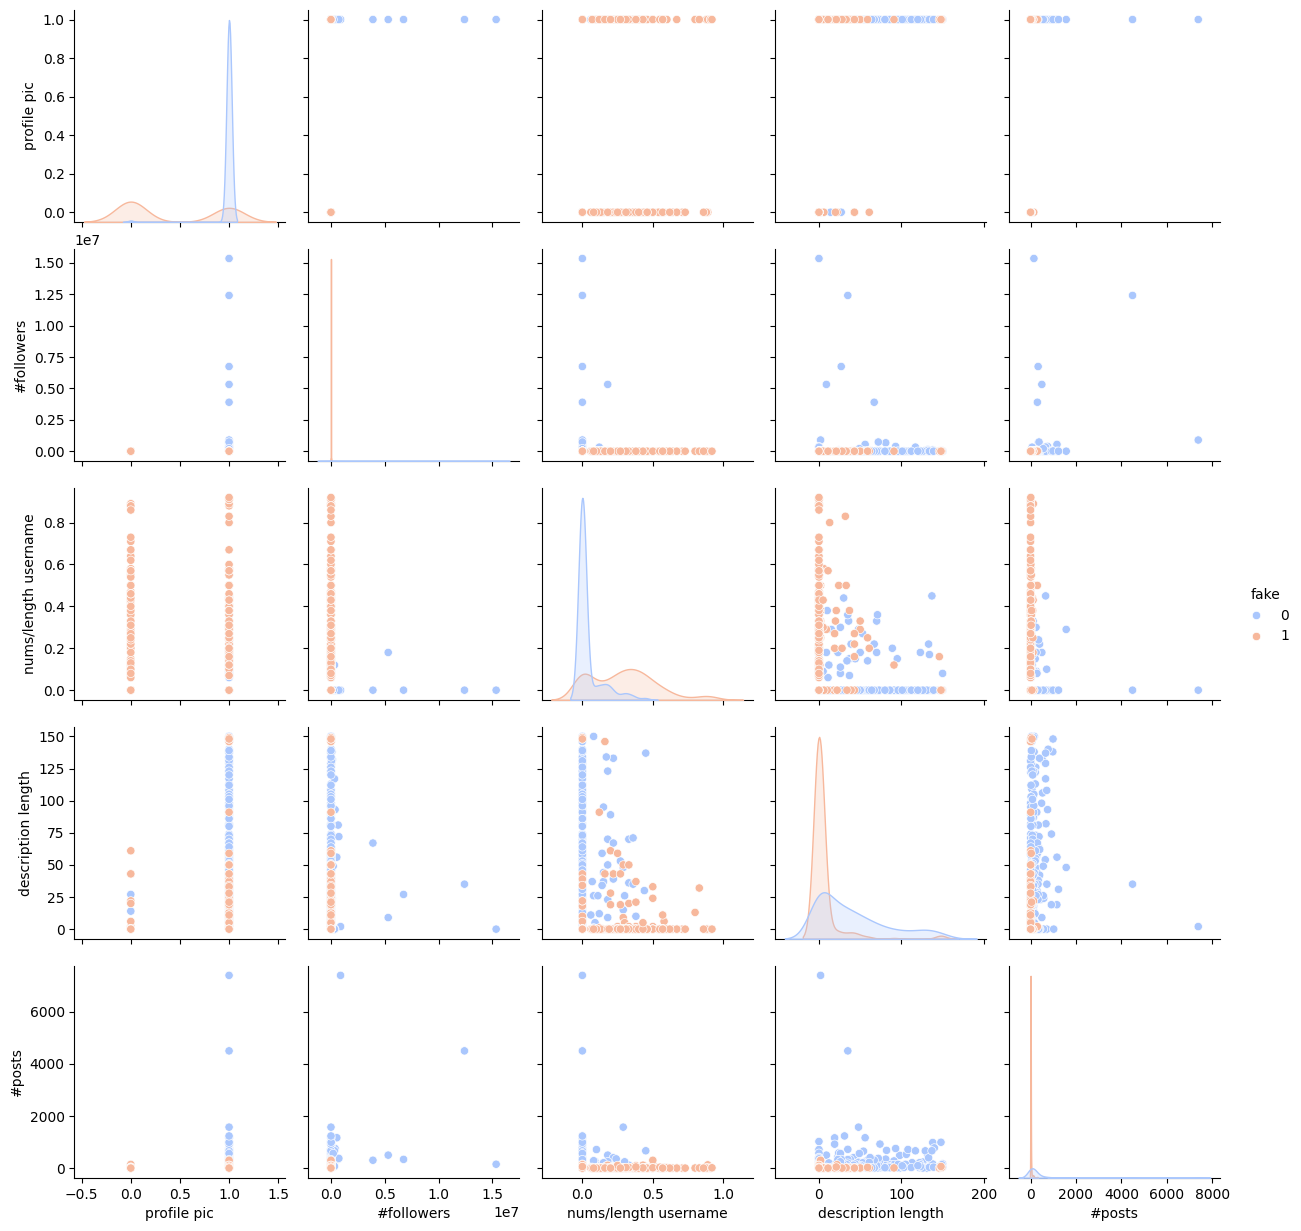


Model Performance Summary:
           Model  Accuracy
0  Random Forest  0.913793
1        XGBoost  0.913793
2            SVM  0.870690


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

# Load the dataset from Google Drive (Replace with actual paths in Colab)
train_path = "train.csv"
test_path = "test.csv"

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# Check for missing values
df_train.fillna(df_train.median(), inplace=True)
df_test.fillna(df_test.median(), inplace=True)

# Convert categorical variables
def encode_categorical(df):
    label_enc = LabelEncoder()
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = label_enc.fit_transform(df[col])
    return df

df_train = encode_categorical(df_train)
df_test = encode_categorical(df_test)

# Split features and target
X = df_train.drop(columns=['fake'])  # Feature set
y = df_train['fake']  # Target variable

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)
y_prob_rf = rf.predict_proba(X_val)[:, 1]

# Train XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_val)
y_prob_xgb = xgb.predict_proba(X_val)[:, 1]

# Train SVM
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_val)
y_prob_svm = svm.predict_proba(X_val)[:, 1]

# Evaluate Models
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Model Performance:")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

# Print Results
evaluate_model("Random Forest", y_val, y_pred_rf)
evaluate_model("XGBoost", y_val, y_pred_xgb)
evaluate_model("SVM", y_val, y_pred_svm)

# Visualization
plt.figure(figsize=(8, 5))
sns.countplot(x=y, palette='coolwarm')
plt.title("Distribution of Fake vs Real Accounts")
plt.show()

# Feature Importance for all models
models = {"Random Forest": rf, "XGBoost": xgb}
for name, model in models.items():
    if hasattr(model, 'feature_importances_'):
        feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
        plt.figure(figsize=(10, 6))
        sns.barplot(x=feature_importance, y=feature_importance.index, palette='viridis')
        plt.title(f"Feature Importance - {name}")
        plt.show()

# Confusion Matrix Heatmap for all models
model_predictions = {"Random Forest": y_pred_rf, "XGBoost": y_pred_xgb, "SVM": y_pred_svm}
for name, y_pred in model_predictions.items():
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# ROC Curve
plt.figure(figsize=(8, 6))
for name, y_prob in zip(["Random Forest", "XGBoost", "SVM"], [y_prob_rf, y_prob_xgb, y_prob_svm]):
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc(fpr, tpr):.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Precision-Recall Curve
plt.figure(figsize=(8, 6))
for name, y_prob in zip(["Random Forest", "XGBoost", "SVM"], [y_prob_rf, y_prob_xgb, y_prob_svm]):
    precision, recall, _ = precision_recall_curve(y_val, y_prob)
    plt.plot(recall, precision, label=f"{name}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# Pairplot of Important Features
sns.pairplot(df_train, vars=feature_importance.index[:5], hue='fake', palette='coolwarm')
plt.show()

# Performance Table
results_df = pd.DataFrame({
    "Model": ["Random Forest", "XGBoost", "SVM"],
    "Accuracy": [accuracy_score(y_val, y_pred_rf), accuracy_score(y_val, y_pred_xgb), accuracy_score(y_val, y_pred_svm)]
})
print("\nModel Performance Summary:")
print(results_df)